# Sinaplots

from here https://cran.r-project.org/web/packages/sinaplot/vignettes/SinaPlot.html

A cool way to display data with as much info as possible, including the number of data points, the distribution and density, mean or median, and outliers. Now in python, because I didn't want to write my 2nd year report this afternoon.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.mlab import GaussianKDE
from matplotlib import cbook
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 7, 5

In [13]:
def sinaplot(dataset, positions=None, vert=True, widths=0.5,
             showmeans=False, showextrema=True, showmedians=False, scaled=True,
             points=100, bw_method=None, ax=None,
             scatter_kwargs=None, line_kwargs=None):
    """
    a cross between a violinplot and a scatterplot, from the R package sinaplot.
    Reimplemented by ripping off the violinplot function from matplotlib and 
    tweaking a few bits.
    """
    
    
    def _kde_method(X, coords):
        # fallback gracefully if the vector contains only one value
        if np.all(X[0] == X):
            return (X[0] == coords).astype(float)
        kde = GaussianKDE(X, bw_method)
        return kde.evaluate(coords)
    vpstats = cbook.violin_stats(dataset, _kde_method, points=points)
    
    if ax is None:
        ax = plt.subplot()
    
    if scatter_kwargs is None:
        scatter_kwargs = dict(s=20, color='b', marker='o', alpha=0.9)
    if line_kwargs is None:
        line_kwargs = dict(color='red', linewidth='1')

    # Collections to be returned
    artists = {}

    N = len(vpstats)
    datashape_message = ("List of violinplot statistics and `{0}` "
                         "values must have the same length")

    # Validate positions
    if positions is None:
        positions = np.arange(1, N + 1)
    elif len(positions) != N:
        raise ValueError(datashape_message.format("positions"))
    positions = positions.reshape((N, 1))
        
    # Validate widths
    if np.isscalar(widths):
        widths = np.ones((N, 1)) * widths
    elif len(widths) != N:
        raise ValueError(datashape_message.format("widths"))
    widths = widths.reshape((N, 1))

    # Calculate ranges for statistics lines
    pmins = -0.1 * np.array(widths) + positions
    pmaxes = 0.1 * np.array(widths) + positions        

    # Check whether we are rendering vertically or horizontally
    if vert:
        perp_lines = ax.hlines
        par_lines = ax.vlines
    else:
        perp_lines = ax.vlines
        par_lines = ax.hlines

    # Calculate jittered scatter positions and render sinaplots
    jittered = []
    means = []
    mins = []
    maxes = []
    medians = []
    
    for i in range(N):
        x = data[:,i]
        xp = vpstats[i]['coords']
        fp = vpstats[i]['vals']
        #Uses numpy interpolate to estimate the limits for each points
        interp = np.interp(x, xp, fp)
        jittered.append(np.asarray([np.random.uniform(-r, r) for r in interp]))
        
        # append some stuff for the means/medians/extremities
        means.append(vpstats[i]['mean'])
        mins.append(vpstats[i]['min'])
        maxes.append(vpstats[i]['max'])
        medians.append(vpstats[i]['median'])
    jittered = np.asarray(jittered)
    
    # get scale_factor (either scaled by largest value in all sinaplots or not scaled)
    if scaled:
        scale_factor = jittered.max()
    else:
        scale_factor = jittered.max(1)
        scale_factor = scale_factor.reshape((N, 1))
    
    jittered = 0.5 * widths * jittered / scale_factor + positions
    
    #plot scatterplot
    if vert:
        artists['scatter'] = plt.scatter(jittered.flatten(),
                                         data.T.flatten(),
                                         **scatter_kwargs)
    else:
        artists['scatter'] = plt.scatter(data.T.flatten(),
                                         jittered.flatten(),
                                         **scatter_kwargs)    
    
    # Render means
    if showmeans:
        artists['cmeans'] = perp_lines(means, pmins, pmaxes, **line_kwargs)
    # Render extrema
    if showextrema:
        artists['cmaxes'] = perp_lines(maxes, pmins, pmaxes, **line_kwargs)
        artists['cmins'] = perp_lines(mins, pmins, pmaxes, **line_kwargs)
        artists['cbars'] = par_lines(positions, mins, maxes, **line_kwargs)

    # Render medians
    if showmedians:
        artists['cmedians'] = perp_lines(medians, pmins, pmaxes, **line_kwargs)

    return artists    

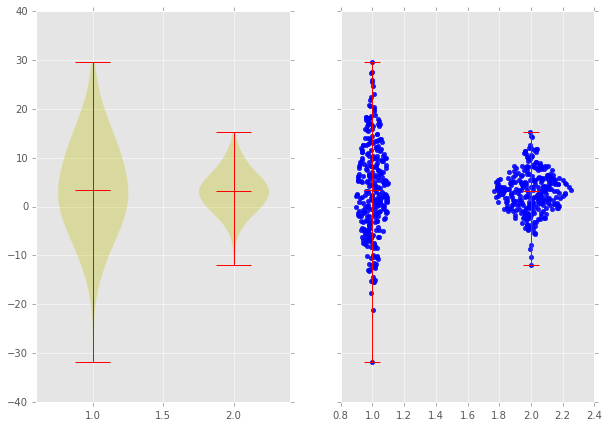

In [14]:
y1 = np.random.normal(4, 10, 300)
y2 = np.random.normal(3, 4, 300)
data = np.vstack((y1, y2)).T

fig, ax = plt.subplots(figsize=(10, 7), ncols=2, sharey=True)
vio = ax[0].violinplot(data, points=200, vert=True, widths=0.5, 
                       showextrema=True, showmedians=True, bw_method=0.5)
sina = sinaplot(data, showmedians=True, showextrema=True,
                scaled=True, vert=True, ax=ax[1])